In [1]:
using Pkg, CairoMakie, LaTeXStrings
Pkg.activate("/Users/jiyong/.juliaenv/image")
using OpenCV, TestImages
cv = OpenCV;

  Activating project at `~/.juliaenv/image`


In [2]:
function arr2mat(arr::Matrix{T}) where T
    cv.Mat(permutedims(stack([arr, ]), [3,2,1]))
end

function arr2mat(arr::Array{T, 3}) where T
    cv.Mat(arr)
end

function img2arr(img)
    T = typeof(img[1, 1].val.i)
    broadcast(q->T(q.val.i),img)
end

function img2mat(img) 
    T = typeof(img[1, 1].val.i)
    tm = broadcast(q->T(q.val.i),img)
    cv.Mat(permutedims(stack([tm, ]), [3,2,1]))
end

function mat2arr(mat::OpenCV.Mat)
    return permutedims(mat.data, [3,2,1])
end

function histogram1d(mat::OpenCV.Mat{T}) where T<:Union{UInt8, UInt16}
    tm = Int32(typemax(T))
    v = cv.calcHist(cv.InputArray[mat,], Int32[0], fill(UInt8(1), size(img1)), Int32[tm+1], Float32[0, tm+1])
    return (0:1:tm, Int64.(v[1,1,:]))    
end

# img0= testimage_dip3e("Fig0108(a) (corn-fluorescence).tif")
# img1 = img2arr(img0)
# img2 = (UInt8(255) .- img1)
# r = arr2mat(cat(img1, img2;dims=2))
# cv.imwrite("inversion.jpg", r)

histogram1d (generic function with 1 method)

In [3]:
img0= testimage_dip3e("Fig0227(a)(washington_infrared).tif")
img1 = cv.resize(img2mat(img0), cv.Size{Int32}(256, 256))
img2 = arr2mat(round.(UInt8, ((img1./255).^0.5)*255))
img3 = arr2mat(round.(UInt8, ((img1./255).^2)*255))
img4 = arr2mat(round.(UInt8, ((img1./255).^5)*255));

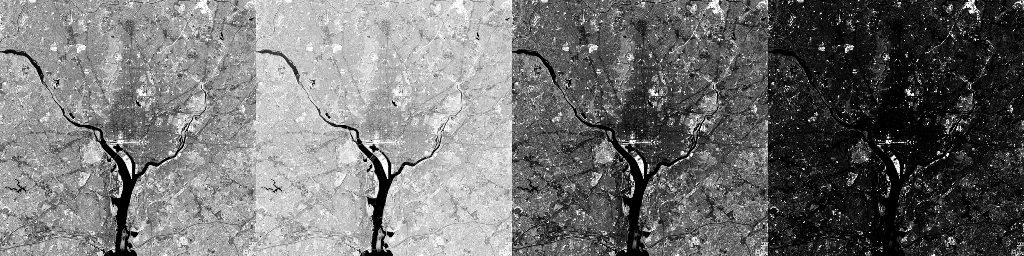

In [5]:
arr2mat(cat(img1, img2, img3, img4; dims=2))

In [6]:
cv.Point(Int32(0), Int32(100))

OpenCV.Point{Int32}(0, 100)

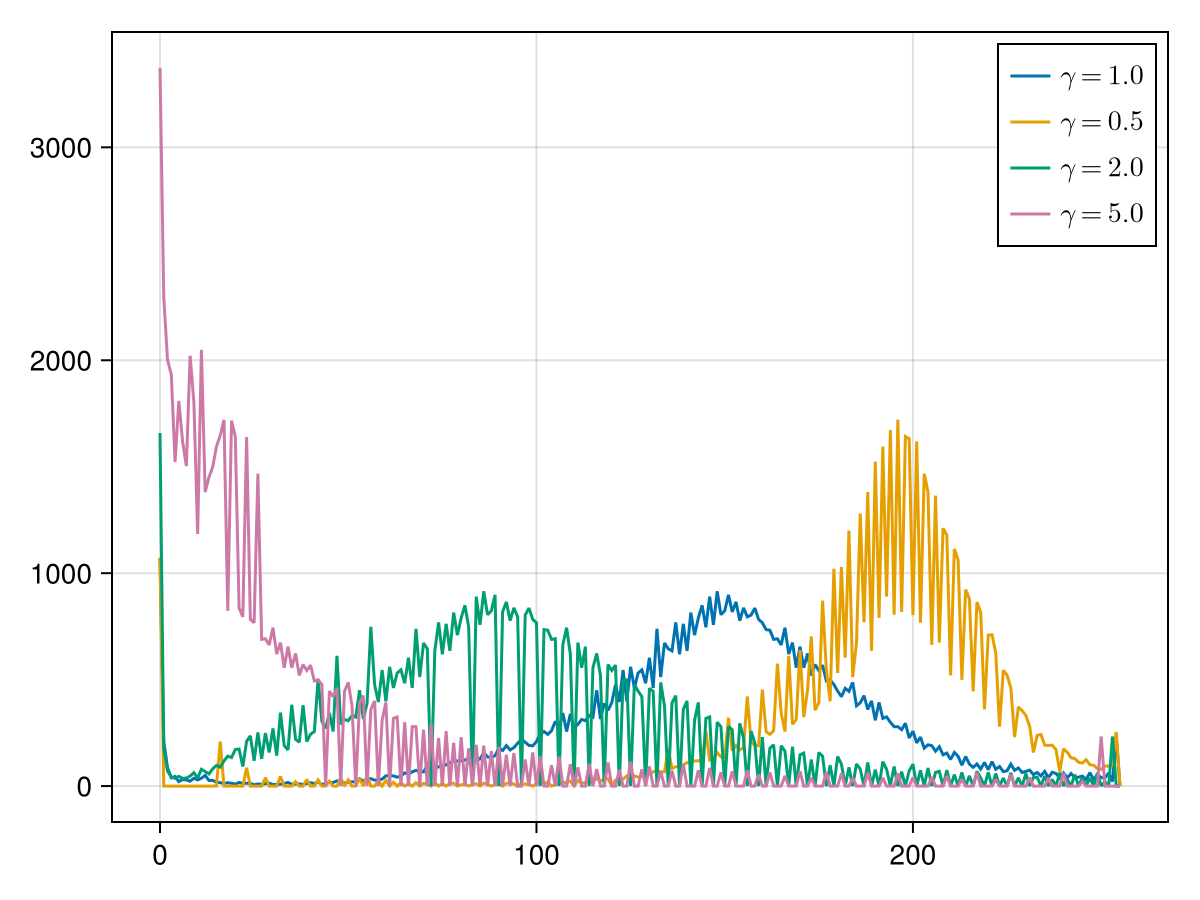

In [7]:
fig = Figure()
ax = Axis(fig[1,1])
for (img, g) in zip([img1, img2, img3, img4], [1.0, 0.5, 2, 5])
    b, v = histogram1d(img)
    lines!(ax, b, v, label = L"\gamma = %$g")
end
axislegend()
fig

In [8]:
#save("histogram_gamma.png", fig)

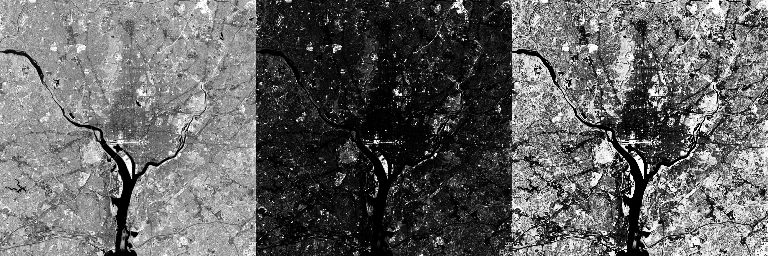

In [10]:
img5 = cv.equalizeHist(img4)
s = arr2mat(cat(img1, img4, img5; dims=2))
# cv.imwrite("equalize_histogram_1.png", s)

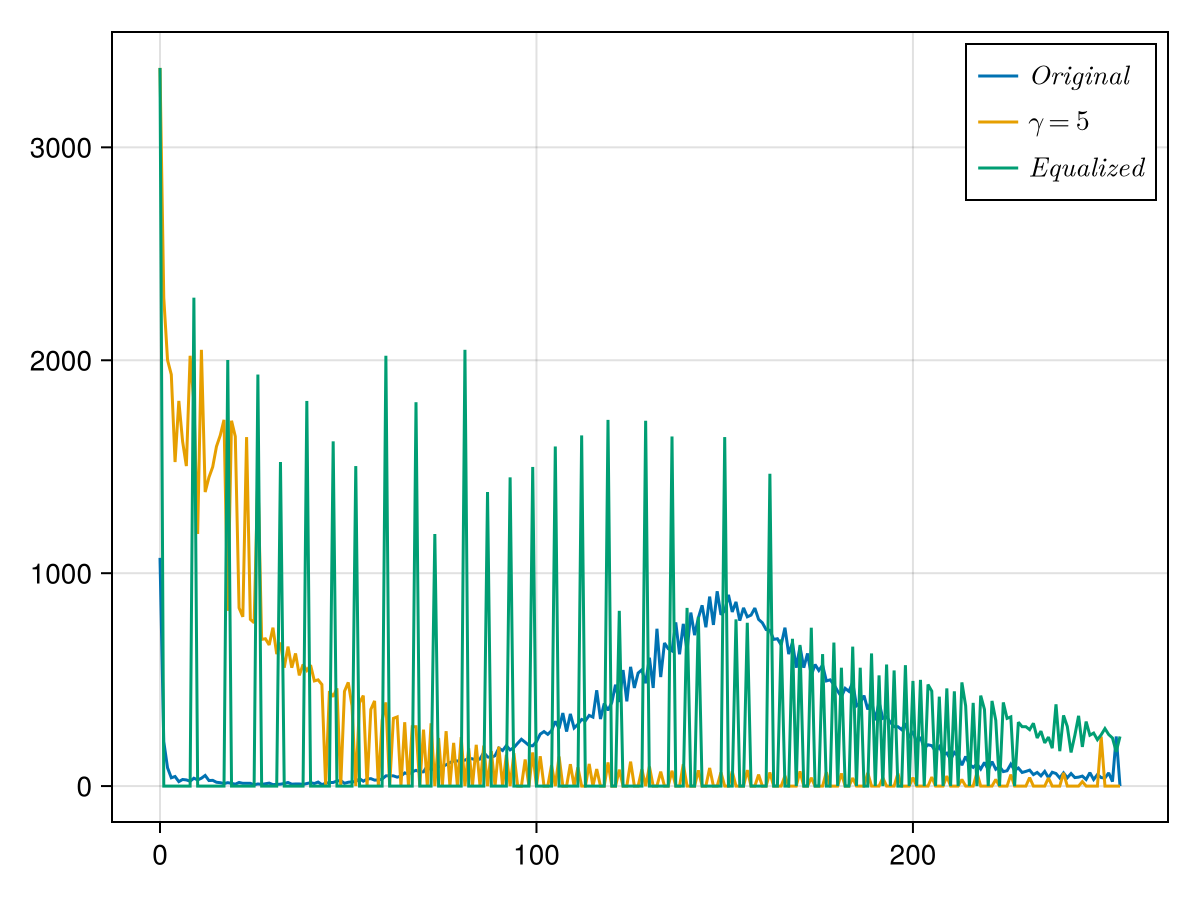

In [11]:
fig = Figure()
ax = Axis(fig[1,1])
for (img, g) in zip([img1, img4, img5], ["Original", "\\gamma=5", "Equalized"])
    b, v = histogram1d(img)
    lines!(ax, b, v, label = L"%$g")
end
axislegend()
fig
#save("equalize_histogram.png", fig)

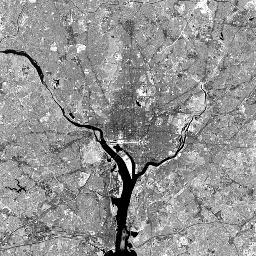

In [12]:
img1

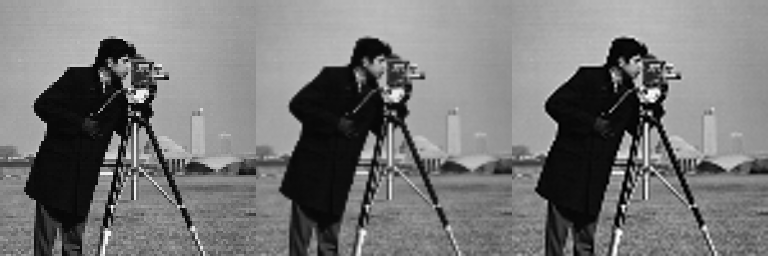

In [73]:
img0= cv.resize(img2mat(testimage("cameraman.tif")), cv.Size{Int32}(100, 100))
img1 = cv.resize(img0, cv.Size(Int32(256), Int32(256));interpolation= cv.INTER_NEAREST)
img2 = cv.resize(img0, cv.Size(Int32(256), Int32(256));interpolation= cv.INTER_LINEAR)
img3 = cv.resize(img0, cv.Size(Int32(256), Int32(256));interpolation= cv.INTER_CUBIC)
s = arr2mat(cat(img1, img2, img3; dims=2))
#cv.imwrite("interpolation.png", s)

In [79]:
img0= img2mat(testimage("cameraman.tif"))

using Distributions
function gaussian_noise(img::OpenCV.Mat{T}, μ, σ, N) where T<:Union{UInt8, UInt16}
    m, n = size(img)[2:3]
    MM = typemax(T)
    Y, X, V = rand(1:m, N), rand(1:n, N), round.(T, rand(truncated(Normal(μ, σ), 0, MM), N))
    img2 = copy(img)
    for (y, x, v) ∈ zip(Y, X, V)
        img2[1, y, x] = v
    end
    return img2
end

function salt_pepper_noise(img::OpenCV.Mat{T}, N) where T<:Union{UInt8, UInt16}
    m, n = size(img)[2:3]
    MM = typemax(T)
    Y, X, V = rand(1:m, N), rand(1:n, N), sample([0, MM], N)
    img2 = copy(img)
    for (y, x, v) ∈ zip(Y, X, V)
        img2[1, y, x] = v
    end
    return img2
end


salt_pepper_noise (generic function with 2 methods)

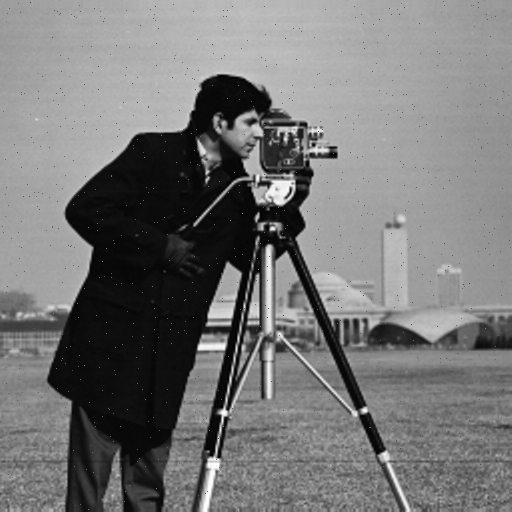

In [80]:
x = gaussian_noise(img0, 100, 10, 1000)

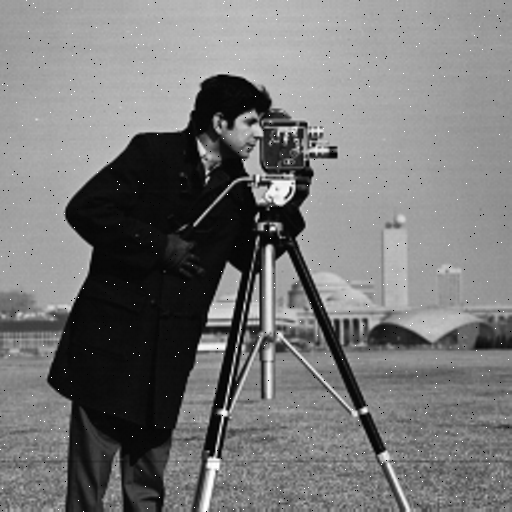

In [81]:
x = salt_pepper_noise(img0, 1000)

In [44]:
function conv2d(img, ker)
    m, n = size(A)
    p, q = size(k)
    @assert isodd(p) && isodd(q)
    c, d = p>>1, q>>1
    
    R = zero(img)

    dx, dy = div(p,2), div(q, 2)
    for j ∈ (dx+1):(m-dx), i ∈ (dy+1):(n-dy)
        
        for t ∈ 1:q, s ∈ 1:p
            R[i, j] += ker[s, t] * img[i-(s-c-1), j-(t-d-1)]
        end
    end

    return R[dy+1:end-dy, dx+1:end-dx]
end

conv2d (generic function with 1 method)

In [45]:
conv2d(A, k)

5×5 Matrix{Int64}:
 12  11  10  12  5
 10   8  12   3  3
  5   6   9   6  4
  8   3  11   4  7
  3   3   8   9  7

In [27]:
div(5, 2)

2